### The steps in this notebook are:
### 1. Build a Random Forest model with all of your data (**X** and **y**)
### 2. Read in the "test" data, which doesn't include values for the target.  Predict home values in the test data with Random Forest model.
### 3. Submit predictions to the competition and see your score.
### 4. Optionally, come back to see if you can improve your model by adding features or changing your model.

In [1]:
# Ressources
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d

In [2]:
# Code you have previously used to load data
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = 'train.csv'

home_data = pd.read_csv(iowa_file_path)

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


Let's see how much Neighborhood affects the SalePrice of a house

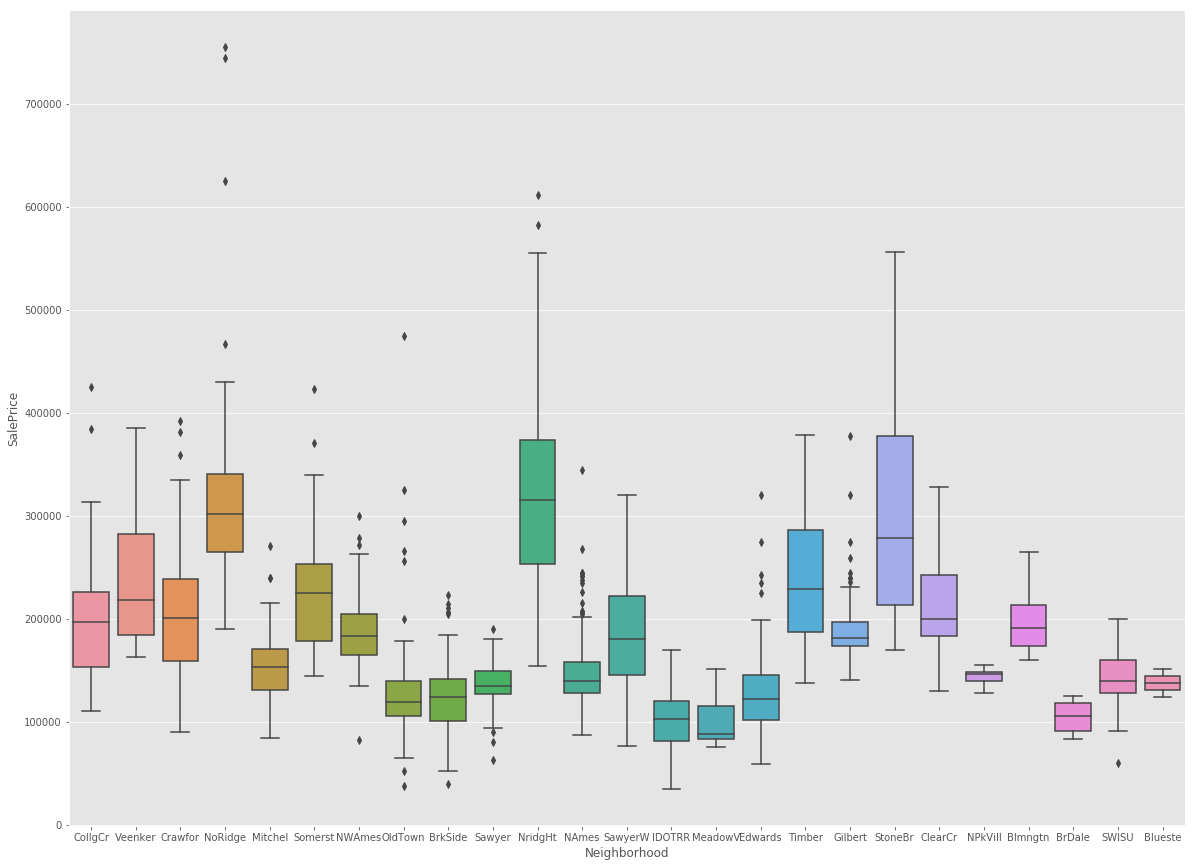

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(20,15))
sns.boxplot(x='Neighborhood', y='SalePrice', data = home_data)

In [4]:
# feature extraction for Neighborhood
neighbor_values = dict()
for neighborhood in home_data.Neighborhood.unique():
    score = [300000, 250000, 200000, 150000, 100000]
    home_data_current = home_data[home_data['Neighborhood'] == str(neighborhood)]

    mw = home_data_current.SalePrice.mean()
    if mw > score[0]:
        home_data.loc[home_data['Neighborhood'] == neighborhood, ['Neighborhood']] = 6
        neighbor_values[neighborhood] = 6
    elif mw <= score[0] and mw > score[1]:
        home_data.loc[home_data['Neighborhood'] == neighborhood, ['Neighborhood']] = 5
        neighbor_values[neighborhood] = 5
    elif mw <= score[1] and mw > score[2]:
        home_data.loc[home_data['Neighborhood'] == neighborhood, ['Neighborhood']] = 4
        neighbor_values[neighborhood] = 4
    elif mw <= score[2] and mw > score[3]:
        home_data.loc[home_data['Neighborhood'] == neighborhood, ['Neighborhood']] = 3
        neighbor_values[neighborhood] = 3
    elif mw <= score[3] and mw > score[4]:
        home_data.loc[home_data['Neighborhood'] == neighborhood, ['Neighborhood']] = 2
        neighbor_values[neighborhood] = 2
    else:
        home_data.loc[home_data['Neighborhood'] == neighborhood, ['Neighborhood']] = 1
        neighbor_values[neighborhood] = 1

home_data['Neighborhood'].astype('int32')

0       3
1       4
2       3
3       4
4       6
       ..
1455    3
1456    3
1457    4
1458    2
1459    2
Name: Neighborhood, Length: 1460, dtype: int32

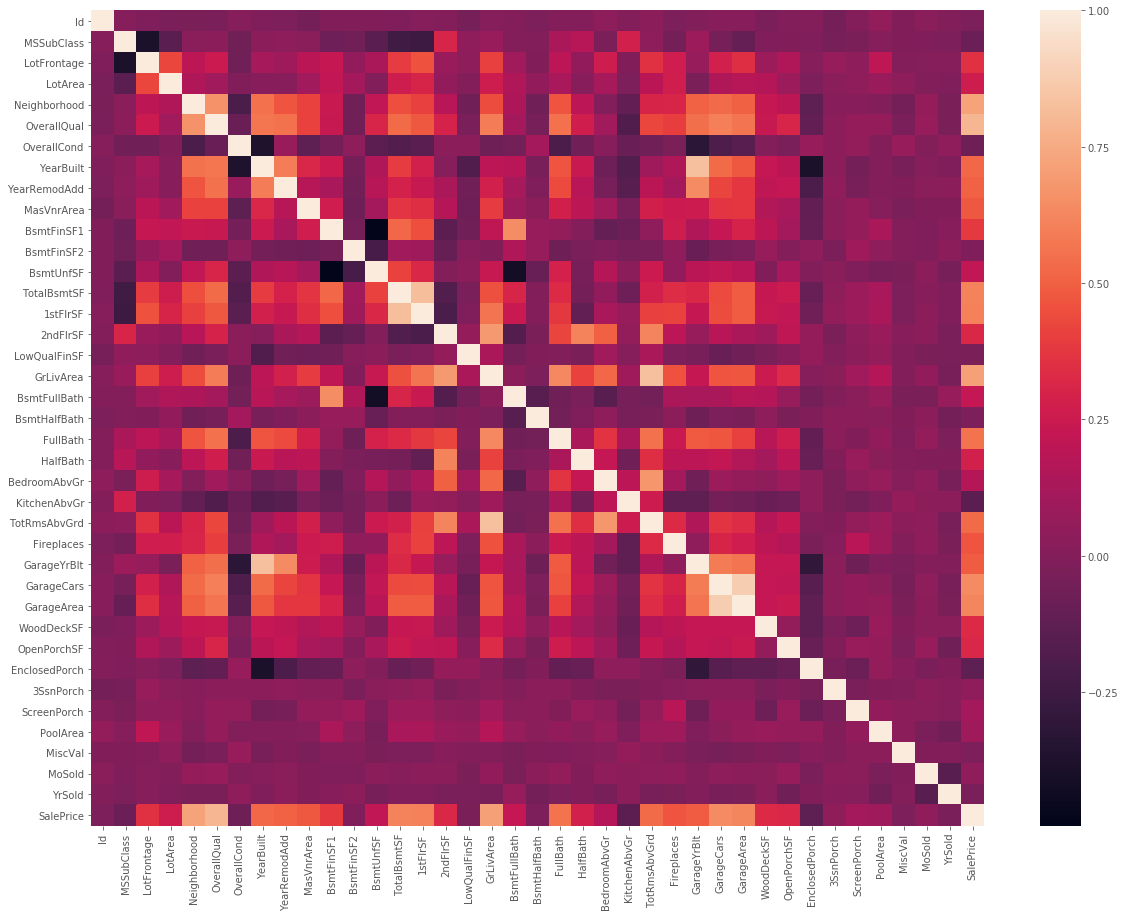

In [5]:
numerical_home_data = home_data._get_numeric_data()
correlation = numerical_home_data.corr()
plt.figure(figsize=(20,15))
sns.heatmap(correlation)

In [6]:
correlation.loc[correlation.SalePrice > 0.5, ['SalePrice']]

,SalePrice
Neighborhood,0.720785
OverallQual,0.790982
YearBuilt,0.522897
YearRemodAdd,0.507101
TotalBsmtSF,0.613581
1stFlrSF,0.605852
GrLivArea,0.708624
FullBath,0.560664
TotRmsAbvGrd,0.533723
GarageCars,0.640409


As the variables *GarageCars* and *GarageArea* show a stron correlation between each other, as well as variables *TotalBsmtSF* and *1stFlrSF* we will only choose one of each for feature selection.

In [7]:
correlation.loc[correlation.SalePrice < -0.5, ['SalePrice']]

,SalePrice


In [8]:
home_data.select_dtypes(include=object)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [9]:

# Create target object and call it y
y = home_data.SalePrice
# Create X
features = ['Neighborhood', 'OverallQual', 'GrLivArea', 'GarageCars', '1stFlrSF', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath']#, 'TotalBsmtSF']
X = home_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Specify Model
iowa_model = DecisionTreeRegressor(random_state=1)
# Fit Model
iowa_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

# Using best value for max_leaf_nodes
iowa_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
iowa_model.fit(train_X, train_y)
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

Validation MAE when not specifying max_leaf_nodes: 27,791
Validation MAE for best value of max_leaf_nodes: 22,932
Validation MAE for Random Forest Model: 19,812


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



# Build a Random Forest model and train it on all of **X** and **y**.

In [10]:
# To improve accuracy, create a new Random Forest model which you will train on all training data
rf_model_on_full_data = RandomForestRegressor(random_state=1)

# fit rf_model_on_full_data on all data from the 
rf_model_on_full_data.fit(X, y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

# Make Predictions


In [11]:
# path to file you will use for predictions
test_data_path = '../input/house-prices-advanced-regression-techniques/test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

# feature extraction for Neighborhood
for neighborhood, z in neighbor_values.items():
    test_data.loc[test_data['Neighborhood'] == str(neighborhood), 'Neighborhood'] = z

test_data['Neighborhood'].astype('int32')

# create test_X which comes from test_data but includes only the columns you used for prediction.
# The list of columns is stored in a variable called features
test_X = test_data[features]
test_X['GarageCars'].fillna(0, inplace=True)

# make predictions which we will submit. 
test_preds = rf_model_on_full_data.predict(test_X)

# The lines below shows you how to save your data in the format needed to score it in the competition
output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})

output.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [12]:
train_X.isnull().sum()

Neighborhood    0
OverallQual     0
GrLivArea       0
GarageCars      0
1stFlrSF        0
YearBuilt       0
TotRmsAbvGrd    0
FullBath        0
dtype: int64